# Train an ML model and practice labeling on MNIST data
### To make your ml model intelligent, you need human generated labels. This tool will help you label unlabelled data and achive that goal. 
* This notebook demonstrates how to train a classfier using semi supervised learning, user interaction and unlabeled data .
* Assumes mnist dataset is unlabelled. We throw out the labels and try to classify only using user's input. 
* Uses facets tool for visualization
* User tags and labels data by clicking on the facets tool
* We modified facets to interactively stores labeled data into browser cache
* Load data from browser's cache to jupyter notebook and trains classifier based on user's choice. 
* Allows user to interactively repeat and retrain. 
* After couple of iteration the model improves significantly

## Requirements
* Installation instructions and install all the following required packages
* Look at setup and installaion section of [Main page](https://github.com/jsiddique/facets/blob/master/README.md)
* Need to clone github repo
* Install the visualizations into Jupyter as an nbextension
* Run this notebook from inside the github folder
* Install numpy, pandas, scikit-learn, matplotlib, Pillow, mnist and other required packages

In [2]:
import sys
sys.path.append("../facets")
from dive import Facets

## Download MNIST Data

In [3]:
!pip install mnist

In [7]:
# set length and height of visualization. Height and width must be same for now. 
sprite_length = 50
sprite_height = 50

In [23]:
import mnist

# We throw out all the labels. The labels will not be used. We will generate them interactively. 
#train_images = mnist.train_images()
#train_labels = mnist.train_labels()
#test_labels = mnist.test_labels()
test_images = mnist.test_images()

In [9]:
x_test = test_images[0:sprite_length*sprite_height].astype(float)
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

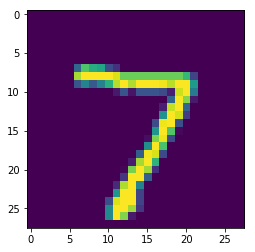

In [10]:
import matplotlib.pyplot as plt
plt.imshow(x_test[0].reshape(28,28))

## Stitch all images in one big sprite atlas file 

In [11]:
def array_to_sprite_atlas(image_array, num_sprites_x, num_sprites_y):
    "Takes an array of images of shape (num_images, img_width, img_height) and splices them together to form a big ass mosaic (sprite atlas)."
    # Mnist arrays are in 0-1 range, PIL needs 0-255
    image_array = image_array * 255
    image_width, image_height = image_array.shape[1], image_array.shape[2]
    atlas_width  = num_sprites_x * image_width
    atlas_height = num_sprites_y * image_height
    # We paste the samples to get indices arranged in the following way:
    # | 0 | 1 | 2 | 3 |
    # | 4 | 5 | 6 | 7 |
    atlas  = Image.new("RGB", (atlas_width, atlas_height), (0, 0, 0))
    for i in range(num_sprites_y): 
        for j in range(num_sprites_x):
            sample = image_array[num_sprites_x * i + j, :, :]
            image = Image.fromarray(sample)
            atlas.paste(image, (j*image_width, i*image_height))
    return atlas

In [75]:
import sklearn
from PIL import Image
import pandas as pd
from dive import Facets

atlas = array_to_sprite_atlas(x_test.reshape(x_test.shape[0], 28, 28), sprite_length, sprite_height)
atlas.save("atlas.jpg", "JPEG")


## Create initial dataframe with only ID

In [92]:
df = pd.DataFrame()
df['Id'] = [x for x in range(len(x_test))]
#jsonstr = df.to_json(orient='records')


## Main Visaulization 
* Try zoom-in, zoom-out. 
* Try the faceting tool on the left hand side. 
* There are 2500 digits in the visualization below
* Perform labeling using the tool on the top
* Select a digit you want to label from "Select Class" dropdown list
* Use ctrl+mouseclick or command+mouseclick on the example you want to label
* Click the reset button to delete all labeled ex
* See below for more examples

In [120]:
# This is the Main visualization cell
fc = Facets()
fc.create_classes(labels=['label_' + str(x) for x in range(0,10)])
fc.define_atlas(df, sprite_width=28, sprite_height=28, atlas_url='atlas.jpg')
fc.render_html('testing.html')
f = open('testing.html', 'r')
t = f.read()
f.close()
from IPython.display import HTML
display(HTML(t))

Reset Select Class label_0 label_1 label_2 label_3 label_4 label_5 label_6 label_7 label_8 label_9
label_0: 0 label_1: 0 label_2: 0 label_3: 0 label_4: 0 label_5: 0 label_6: 0 label_7: 0 label_8: 0 label_9: 0 Total: 0
""


## How to do first round labeling
### [Click to Label](http://localhost:8100/testing.html)
* Select the digit/number/class you want to label <img src="screenshots/pick_group.png">


* Have 2-3 good examples for each class by clicking on the digits. In the figure below we have chosen to label digit 0. <img src="screenshots/click_examples.png">



* Must have at least one good example for each class for this notebook to work. The id of the corresponding example that was chosen by the use will be saved in browser's local storage and later on will be retrieved to train a model. So the model will learn from the examples chosen by the user.

## Step 2: Initialize Dictionary

In [121]:
is_init_dict = False
if not is_init_dict:
    is_init_dict = True
    chosen_examples_dict = {}
    for x in range(0,10):
        chosen_examples_dict['label_'+str(x)] = ''

## Step 3: Get labelled example chosen by the user  (repeat after step 5 )

In [122]:
fc.create_labeled_variables('chosen_examples_dict')

<IPython.core.display.Javascript object>

In [123]:
fc.create_labeled_variables('chosen_examples_dict')

<IPython.core.display.Javascript object>

In [124]:
chosen_examples_dict

{'label_0': ['2485', '2479'],
 'label_1': ['2316', '2164'],
 'label_2': ['2260', '2311'],
 'label_3': ['1166', '1265'],
 'label_4': ['1849', '1985'],
 'label_5': ['1833', '1672'],
 'label_6': ['1017', '1362'],
 'label_7': ['2317', '1776'],
 'label_8': ['1756', '1651'],
 'label_9': ['759', '678', '434']}

In [125]:
item_labels_dict = {}
for x in chosen_examples_dict:
    for y in  chosen_examples_dict[x]:
        item_labels_dict[y] = x
item_labels_dict

{'1017': 'label_6',
 '1166': 'label_3',
 '1265': 'label_3',
 '1362': 'label_6',
 '1651': 'label_8',
 '1672': 'label_5',
 '1756': 'label_8',
 '1776': 'label_7',
 '1833': 'label_5',
 '1849': 'label_4',
 '1985': 'label_4',
 '2164': 'label_1',
 '2260': 'label_2',
 '2311': 'label_2',
 '2316': 'label_1',
 '2317': 'label_7',
 '2479': 'label_0',
 '2485': 'label_0',
 '434': 'label_9',
 '678': 'label_9',
 '759': 'label_9'}

In [126]:
df['Chosen'] = df.Id.apply(lambda x: item_labels_dict[str(x)]  if str(x) in item_labels_dict else -1)

In [127]:
df.Chosen.value_counts()

-1         2479
label_9       3
label_8       2
label_3       2
label_2       2
label_1       2
label_0       2
label_7       2
label_6       2
label_5       2
label_4       2
Name: Chosen, dtype: int64

In [128]:
df_train = df.copy()
one_dim = x_test.reshape(x_test.shape[0], 28*28)
df_train['Features'] = [one_dim[i].tolist() for i in range(x_test.shape[0])]
df_tmp = df_train[df_train.Chosen != -1]
df_tmp = df_train[df_train.Chosen != -1]
X = df_tmp.Features.values.tolist()
Y = df_tmp.Chosen.apply(lambda x: x).values
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50)
clf = clf.fit(X, Y)
p_arr = clf.predict_proba(df_train.Features.values.tolist())
_labels = clf.predict(df_train.Features.values.tolist())
zero_prob = [x[0] for x in p_arr]
one_prob = [x[1] for x in p_arr]
two_prob = [x[2] for x in p_arr]
three_prob = [x[3] for x in p_arr]
four_prob = [x[4] for x in p_arr]
five_prob = [x[5] for x in p_arr]
six_prob = [x[6] for x in p_arr]
seven_prob = [x[7] for x in p_arr]
eight_prob = [x[8] for x in p_arr]
nine_prob = [x[9] for x in p_arr]
df = pd.DataFrame()
df['Id'] = [x for x in range(len(x_test))]
df['Labels'] = _labels
df['ProbOne'] = one_prob
df['ProbZeros'] = zero_prob
df['ProbTwos'] = two_prob
df['ProbThrees'] = three_prob
df['ProbFours'] = four_prob
df['ProbFives'] = five_prob
df['ProbSixs'] = six_prob
df['ProbSevens'] = seven_prob
df['ProbEights'] = eight_prob
df['ProbNines'] = nine_prob
df['IsTraining'] = df_train.Chosen

In [129]:
df.head()

,Id,Labels,ProbOne,ProbZeros,ProbTwos,ProbThrees,ProbFours,ProbFives,ProbSixs,ProbSevens,ProbEights,ProbNines,IsTraining
0,0,label_7,0.06,0.04,0.04,0.06,0.1,0.04,0.02,0.34,0.06,0.24,-1
1,1,label_3,0.16,0.04,0.14,0.24,0.1,0.06,0.06,0.06,0.10,0.04,-1
2,2,label_1,0.36,0.04,0.06,0.16,0.1,0.00,0.04,0.12,0.08,0.04,-1
3,3,label_0,0.08,0.18,0.14,0.18,0.0,0.06,0.06,0.04,0.08,0.18,-1
4,4,label_4,0.00,0.06,0.06,0.14,0.2,0.08,0.10,0.04,0.14,0.18,-1
